# Benchmark ComBind on PDB ligands

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from benchmark import benchmark, load_chembl, ligand_level_performance

%matplotlib inline

In [2]:
data = load_chembl('stats7', 'pdb')

F2
B2AR
B1AR
CHK1
PLK1
PYGM
P00760
CHRM3
CDK2
PTPN1
SMO
JAK2
F10
NR3C1
F11
5HT2B
NR3C2
ERA
MGLUR5
SIGMAR1
BACE1
ELANE
GLUT1
MAPK14
PLAU
AR
PDE10A
MEK1
TRPV1
HSP90AA1
BRAF
A2AR
SLC6A4
VDR
BRD4
DAT
DHFR


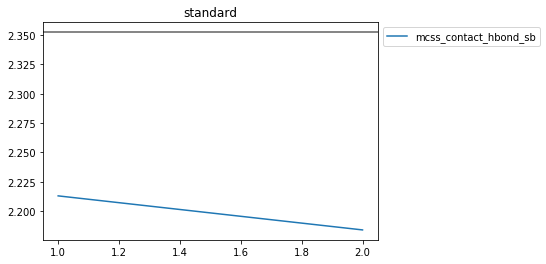

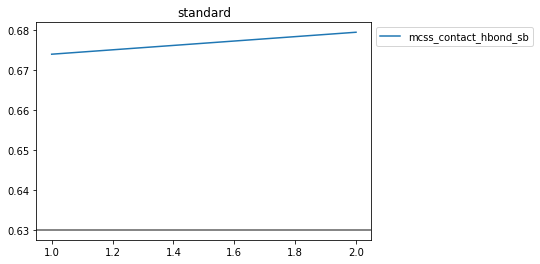

In [3]:
def sweep(data, mode, thresh = None):
    def metric(x):
        if thresh is None:
            return np.mean(x)
        return np.mean(np.array(x) <= thresh)
    
    alpha_factors = [1.0, 2.0]
    #features = sorted(set(k[2] for k in data[mode].keys()))
    features = ['mcss_contact_hbond_sb']
    for feature in features:
        performances = []
        for alpha_factor in alpha_factors:
            performances += [ligand_level_performance(data[mode][(0, alpha_factor, feature)])]
        if len(alpha_factors) > 1:
            plt.plot(alpha_factors,
                     [metric(p[1]) for p in performances],
                     label = feature)
        else:
            plt.plot([0, 1], [metric(performances[0][1])]*2, label = feature)
        for p in performances:
            plt.axhline(metric(p[0]), c = 'grey')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(mode)
    plt.show()

sweep(data, 'standard')
thresh = 2.0
sweep(data, 'standard', thresh)

In [4]:
def drug_average(n):
    families = {
        'GPCR': ['5HT2B', 'A2AR', 'B1AR', 'B2AR', 'CHRM3','SMO', 'MGLUR5'],
        'Kinase': ['BRAF', 'CDK2', 'CHK1', 'JAK2', 'PLK1', 'MAPK14', 'MEK1'],
        #'Ion Channel': ['TRPV1'],
        'Transporter': ['SLC6A4', 'GLUT1', 'DAT'],
        'Nuclear Receptor': ['NR3C2', 'NR3C1', 'AR', 'VDR', 'ERA'],
        'Peptidase': ['F2', 'F10', 'F11', 'PLAU', 'P00760', 'BACE1'],
        'Other': ['PYGM', 'PTPN1', 'BRD4', 'HSP90AA1', 'PDE10A', 'SIGMAR1', 'ELANE', 'TRPV1', 'DHFR']
    }
    targets = {'GPCR': 0.33,
               'Kinase': 0.03,
               #'Ion Channel': 0.18,
               'Nuclear Receptor': 0.16,
               'Other': 0.20+0.18,
               'Peptidase': 0.03,
               'Transporter': 0.07}

    g_t, c_t = 0, 0
    for family, members in families.items():
        glide, combind, best = ligand_level_performance(data['standard'][(0, n, 'mcss_contact_hbond_sb')], members)
        glide, combind = np.mean(np.array(glide) < 2.0), np.mean(np.array(combind) < 2.0)
        print(family, targets[family], glide, combind)
        
        g_t += targets[family] * glide
        c_t += targets[family] * combind

    print(g_t, c_t)

In [5]:
drug_average(1.0)
drug_average(2.0)

GPCR 0.33 0.36585365853658536 0.5121951219512195
Kinase 0.03 0.7340425531914894 0.6702127659574468
Transporter 0.07 0.5 0.75
Nuclear Receptor 0.16 0.896551724137931 0.8620689655172413
Peptidase 0.03 0.5428571428571428 0.6142857142857143
Other 0.38 0.5555555555555556 0.6666666666666666
0.5485980851717122 0.6513237124672893
GPCR 0.33 0.36585365853658536 0.4634146341463415
Kinase 0.03 0.7340425531914894 0.7340425531914894
Transporter 0.07 0.5 0.5833333333333334
Nuclear Receptor 0.16 0.896551724137931 0.8620689655172413
Peptidase 0.03 0.5428571428571428 0.6285714285714286
Other 0.38 0.5555555555555556 0.6555555555555556
0.5485980851717122 0.6216807276483833


516 valid ligands
Ttest_relResult(statistic=3.144352413418711, pvalue=0.0017606025182645728)
ComBind improves pose for 93 of 516 ligands
ComBind degrades pose for 54 of 516 ligands
All Ligands RMSD Glide: 3.793261462002044, 0.44573643410852715
All Ligands RMSD ComBind: 3.5592385670466458, 0.47674418604651164


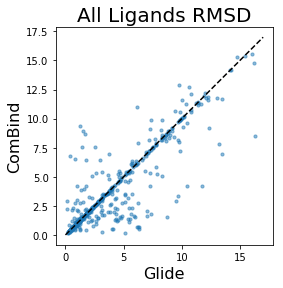

Mean RMSD Glide: 3.7100340495777258
Mean RMSD ComBind: 3.4079048886983165


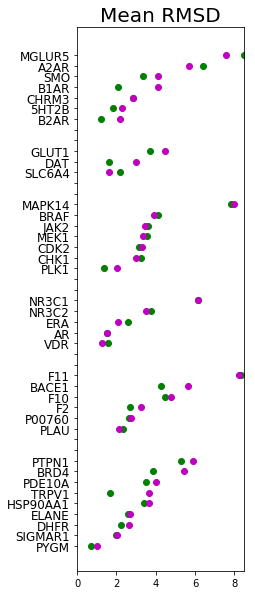

Fraction Near-Native Glide: 0.427740310828546
Fraction Near-Native ComBind: 0.4856318826907062


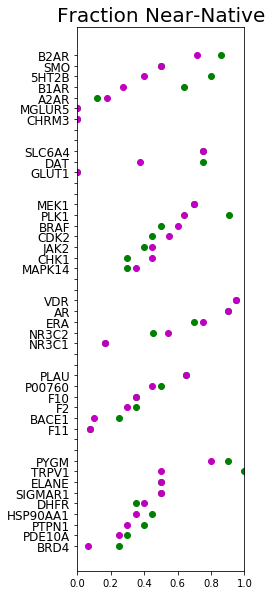

In [6]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')])

516 valid ligands
Ttest_relResult(statistic=3.7274778202003325, pvalue=0.00021483195150726788)
ComBind improves pose for 79 of 516 ligands
ComBind degrades pose for 38 of 516 ligands
All Ligands RMSD Glide: 3.793261462002044, 0.44573643410852715
All Ligands RMSD ComBind: 3.5291568301324556, 0.4806201550387597


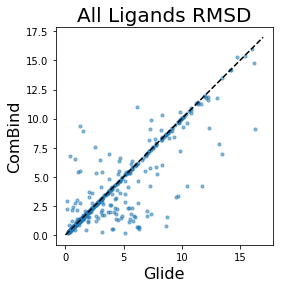

Mean RMSD Glide: 3.7100340495777258
Mean RMSD ComBind: 3.5044360239370933


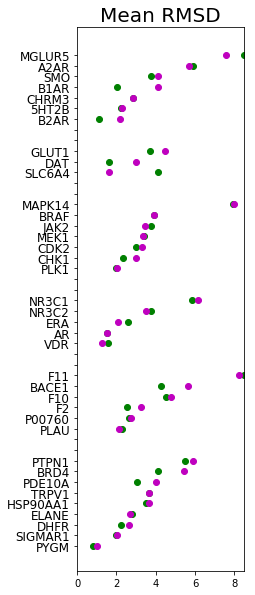

Fraction Near-Native Glide: 0.427740310828546
Fraction Near-Native ComBind: 0.45504220210102553


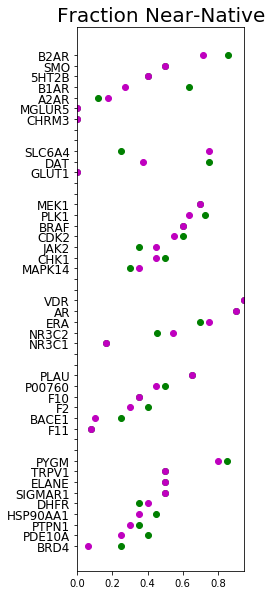

In [7]:
benchmark(data['standard'][(0, 2.0, 'mcss_contact_hbond_sb')])